# Setup

In [80]:
# main.py
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import globals as gl
import factory


'''Validating data and create plots'''

gl.init()
# factory.Filter.remove_movement_tutorials()
# factory.Filter.remove_shield_tutorial()

dataframes = gl.dataframes
conc_dataframes = gl.conc_dataframes
plt.tight_layout()

# Playing time per user

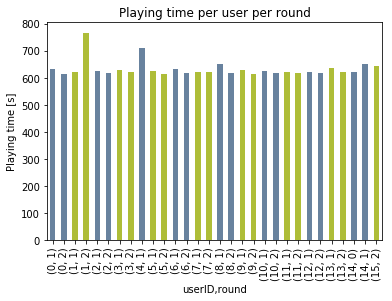

In [81]:
'''Plot: Playing time per user 
'''
plt.ylabel('Playing time [s]')
plt.title('Playing time per user per round')
colors = factory.Helpers.get_colors()

time_df = conc_dataframes.groupby(['userID', 'round'])['Time'].max()
time_df.plot.bar(color=factory.Helpers.get_colors())
plt.savefig(gl.svn_base_path + '/Plots/Playing_time_per_user.pdf')

# Average Heartrate over all games

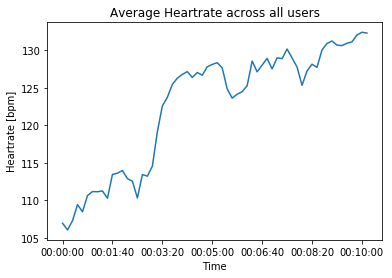

In [88]:
'''Plot: Average Heartrate 
'''

import datetime

plt.figure()
plt.ylabel('Heartrate [bpm]')
plt.xlabel('Playing time [s]')
plt.title('Average Heartrate across all users')

resolution = 10 # resample every x seconds -> the bigger, the smoother

min_time = time_df.min()
cutted = conc_dataframes[conc_dataframes['Time']<min_time] # Cut all dataframes to the same minimal length
conc_with_hr = cutted[cutted['Heartrate']!=-1] # Filter out dataframes without HR
df_copy = conc_with_hr.copy() # to prevent SettingWithCopyWarning
df_copy['Time'] = conc_with_hr['Time'].apply(lambda x: datetime.timedelta(seconds=x)) # Convert Time into TimeDeltaIndex, such that we can resmaple it
avg_hr_df = df_copy.groupby(['Time'])['Heartrate'].mean() # Take mean over all logfiles
avg_hr_df_resampled = avg_hr_df.resample(str(resolution)+'S').mean() # Resample it to 1 seconds

avg_hr_df_resampled.plot()
plt.savefig(gl.svn_base_path + '/Plots/Heartrate_series.pdf')

# Mean and std HR boxplot

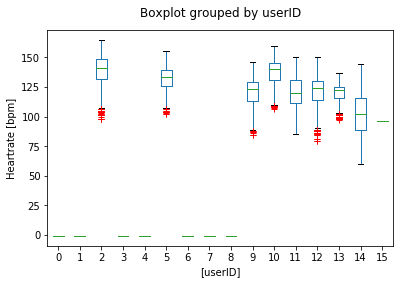

In [83]:
'''Plot: Mean and std bpm per user in a box-chart
'''

df2 = conc_dataframes.pivot(columns=conc_dataframes.columns[1], index=conc_dataframes.index)
df2.columns = df2.columns.droplevel()
conc_dataframes[['Heartrate','userID']].boxplot(by='userID', grid=False, sym='r+')
plt.ylabel('Heartrate [bpm]')
plt.title('')
plt.savefig(gl.svn_base_path + '/Plots/Mean_heartrate.pdf')

# Heartrate Change

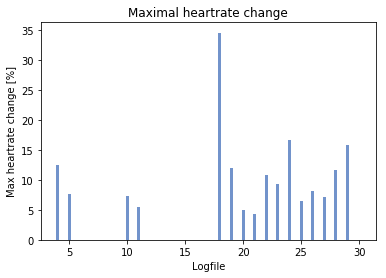

In [84]:
''' Plot Heartrate change
    TODO: Average the two rounds per user!
'''
bpm_changes_max = []  # Stores max. absolute change in HR per logfile 
bpm_changes_rel = [] # Stores max. percentage change in HR per logfile 
X = [] # 
for idx, df in enumerate(dataframes):
    if not (df['Heartrate'] == -1).all():
        X.append(idx)
        percentage_change = np.diff(df['Heartrate']) / df['Heartrate'][:-1] * 100.
        bpm_changes_max.append(percentage_change.max())
        bpm_changes_rel.append(percentage_change)

# plt.ylabel('#Times HR changed')
# plt.xlabel('Change in Heartrate [%]')
# for idx, l in enumerate(bpm_changes_rel):
    # plt.figure()
    # plt.title('Heartrate change for plot' + str(idx))
    # plt.hist(l, color='#7293cb')
    # plt.savefig(gl.svn_base_path + '/Plots/Heartrate Histograms/heartrate_change_percentage' + str(idx) + '.pdf')


plt.figure()
plt.title('Maximal heartrate change')
plt.ylabel('Max heartrate change [%]')
plt.xlabel('Logfile')
plt.bar([x for x in X], bpm_changes_max, color='#7293cb', width=0.25)
plt.savefig(gl.svn_base_path + '/Plots/heartrate_change_abs.pdf')